### Загрузим основные пакеты

In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [2]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(12,8)})

### Еще один непараметрический метод (Nadaraya Watson) основан на ядерном сглаживании

<AxesSubplot:ylabel='Count'>

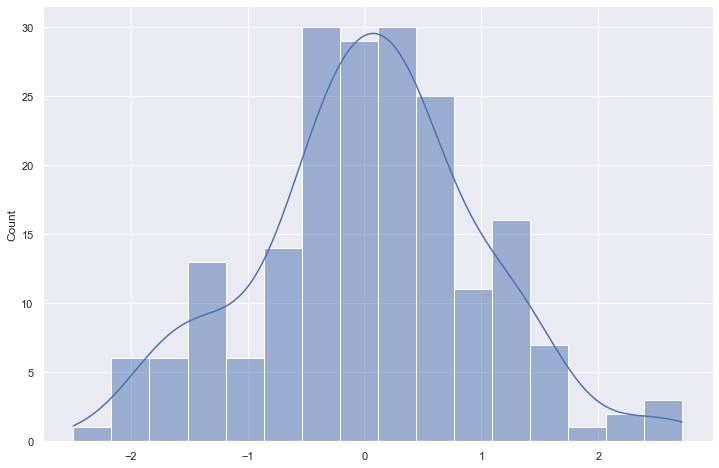

In [3]:
size = 200
x = np.random.normal(size = size)
sb.histplot(x, kde = True)

### Что такое ядерное сглаживание? Это способ оценить плотность
$$ f(x) \approx \sum_{data} K(x_i - x), \quad \text{где $K$ это ядро}$$
### Есть три способа как это запрогать
- прибить все к решетке np.histogram и сделать np.convolve с ядром
- написать цикл, сложность $O(n^2)$ где $n$ число наблюдений
- отсортировать, написать цикл, сложность $O(nk)$ где $k$ это грубо говоря диаметр ядра

### Первый

In [4]:
count = np.zeros(600)

for i in x:
    count[np.clip(int(i*100)+300,0,599)] += 1

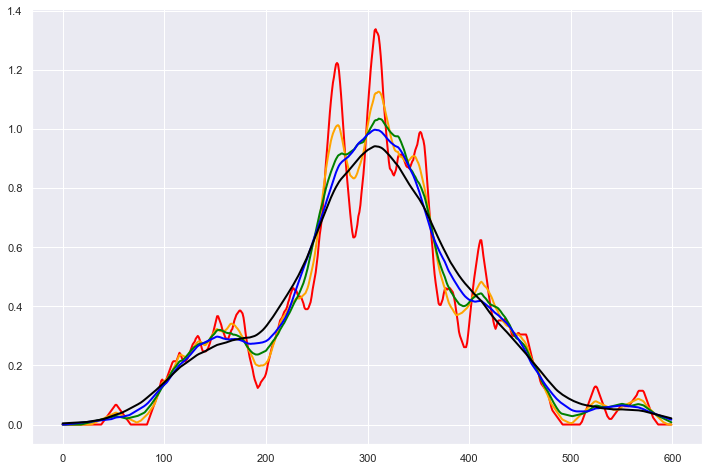

In [5]:
for band, color in zip([15,25,35,50,75],['red','orange', 'green', 'blue', 'black']):
    kernel = np.array(list(range(band))+list(reversed(np.arange(band))))
    plt.plot(np.convolve(count,kernel, mode = 'same')/np.sum(kernel), linewidth = 2, color = color)

### Второй

In [6]:
band = 25

def kernel(d):
    return np.maximum(band-np.abs(d),0)

count = np.zeros(600)
for i in range(600):
    for j in x:
        count[i] += kernel(300+j*100-i)

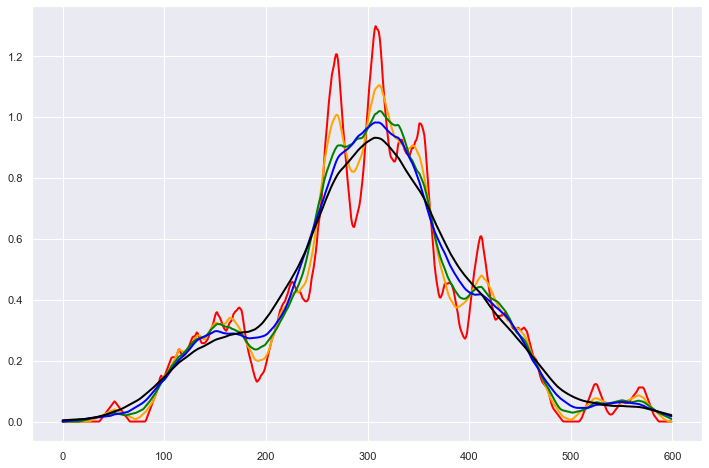

In [7]:
for band, color in zip([15,25,35,50,75],['red','orange', 'green', 'blue', 'black']):
    def kernel(d):
        return np.maximum(band-np.abs(d),0)/(band*band)

    count = np.zeros(600)
    for i in range(600):
        for j in x:
            count[i] += kernel(300+j*100-i)
            
    plt.plot(count, linewidth = 2, color = color)

### Где применяются оценки плотности?

### Первое применение это непараметрическая регрессия (Nadaraya Watson) что есть по сути взвешенная регрессия на константу, если приглядеться
$$ Е[y|x] = \frac{\int y f(x,y) dy}{f(y)} = \frac{\int y f(x,y) dy}{\int 1 f(x, y) dy} \approx \frac{\sum_{data} y_i K(x_i -x)}{\sum_{data} K(x_i - x)} = \sum w_i y_i$$

### Второе применение это обратная стратегия в аукционе первой цены (Guerre Perrigne Vuong)
$$ \beta^{-1}(x) = x + \frac{\int_0^x f(y) dy}{f(x)} \approx x + \frac{\sum_{data < x} K(x_i - x)}{\sum_{data} K(x_i - x)}$$

### Из за деления на плотность (знаменатель) эти оценки относительно сложно имплементировать, это целое искусство. Также, из за двойного цикла такой посчет довольно медленный, если не использовать дополнительные пакеты типа numba. Готовая непараметрическая регрессия есть в пакете statsmodels и в пакете sklearn.

In [8]:
from statsmodels.nonparametric.kernel_regression import KernelReg as KernelReg

In [66]:
sig(KernelReg)

<Signature (endog, exog, var_type, reg_type='ll', bw='cv_ls', ckertype='gaussian', okertype='wangryzin', ukertype='aitchisonaitken', defaults=None)>

### В терминологии этого пакета
- local linear это loess
- local constant это nadaraya-watson

In [9]:
size = 500

def create(size):
    x=np.random.uniform(size=size)
    # Не забудем центрировать !!!
    x=x-x.mean()
    eps=np.random.uniform(size=size)*2
    eps=eps-eps.mean()
    y = 3*np.sin(4*np.pi*x) + 3*eps
    return x, y

x, y = create(size)

In [10]:
model = KernelReg(y, x, var_type = 'c', reg_type='lc')

In [11]:
print(dir(model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_bw_method', '_compute_bw', '_compute_dispersion', '_compute_efficient', '_compute_reg_bw', '_cv_ls', '_cv_ml', '_est_loc_constant', '_est_loc_linear', '_get_class_vars_type', '_normal_reference', '_set_bw_bounds', '_set_defaults', 'aic_hurvich', 'bw', 'ckertype', 'cv_loo', 'data', 'data_type', 'efficient', 'endog', 'est', 'exog', 'fit', 'k_vars', 'loo_likelihood', 'n_jobs', 'n_res', 'n_sub', 'nobs', 'okertype', 'r_squared', 'randomize', 'reg_type', 'return_median', 'return_only_bw', 'sig_test', 'ukertype', 'var_type']


In [12]:
fit = model.fit()

In [13]:
fit[0].shape, fit[1].shape

((500,), (500, 1))

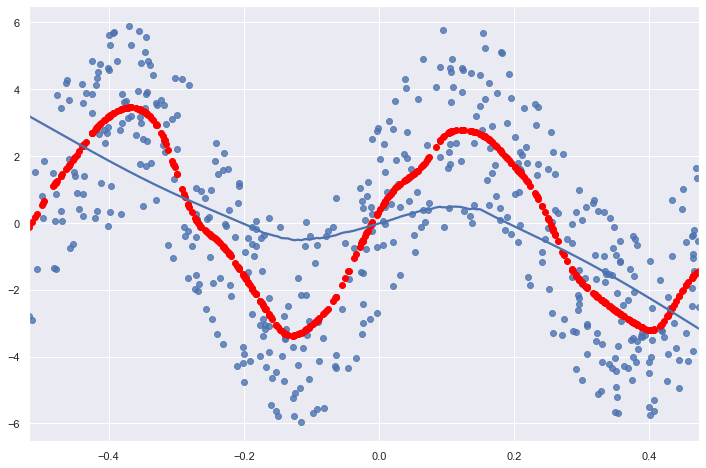

In [14]:
sb.regplot(x=x, y=y, lowess = True)
plt.scatter(x, fit[0], color = 'red')

### У непараметрической регрессии разрешено использовать много иксов.